In [29]:
!pip3 install opencv-python

In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import cv2

In [31]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(25)
    f.set_facecolor("white")
    if len(images) == 1:
        axes.imshow(images[0], cmap, alpha=None)
        axes.set_title(captions[0])
        return
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

## Read some video

In [32]:
vidcap = cv2.VideoCapture('../datasets/2016-ITS-BrnoCompSpeed/dataset/session0_right/video.avi')
success,image = vidcap.read()
count = 0
images = []
while success:
    print(f"Handling frame {count}")
    cv2.imwrite(f"./frames/frame%d.jpg" % count, image)     # save frame as JPEG file
    # if len(images) > 0:
    #     img_diff = np.mean(images[-1] - image)
    #     print(img_diff)
    #     if img_diff > 100:
    #         print(f"Invalid? frame {count}")
    #         success,image = vidcap.read()
    #         count += 1
    #         continue

    images.append(image)
    print('Read a new frame: ', success)
    success,image = vidcap.read()
    count += 1

    if count >= 100: ####
        break

len(images)

Handling frame 0
Read a new frame:  True
Handling frame 1
Read a new frame:  True
Handling frame 2
Read a new frame:  True
Handling frame 3
Read a new frame:  True
Handling frame 4
Read a new frame:  True
Handling frame 5
Read a new frame:  True
Handling frame 6
Read a new frame:  True
Handling frame 7
Read a new frame:  True
Handling frame 8
Read a new frame:  True
Handling frame 9
Read a new frame:  True
Handling frame 10
Read a new frame:  True
Handling frame 11
Read a new frame:  True
Handling frame 12
Read a new frame:  True
Handling frame 13
Read a new frame:  True
Handling frame 14
Read a new frame:  True
Handling frame 15
Read a new frame:  True
Handling frame 16
Read a new frame:  True
Handling frame 17
Read a new frame:  True
Handling frame 18
Read a new frame:  True
Handling frame 19
Read a new frame:  True
Handling frame 20
Read a new frame:  True
Handling frame 21
Read a new frame:  True
Handling frame 22
Read a new frame:  True
Handling frame 23
Read a new frame:  True
Ha

100

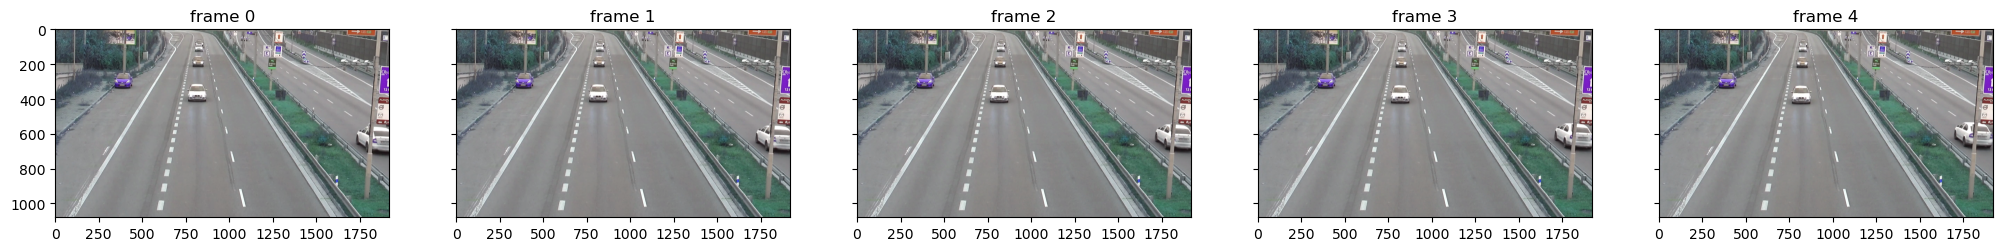

In [33]:
imgs_to_plot = images[:5]
plot_image(imgs_to_plot, captions=[f"frame {i}" for i in range(len(imgs_to_plot))])

## Helper functions for Lane / Edge Detection

In [34]:
def adjust_contrast_brightness(img, contrast:float=1.0, brightness:int=0):
    """
    Adjusts contrast and brightness of an uint8 image.
    contrast:   (0.0,  inf) with 1.0 leaving the contrast as is
    brightness: [-255, 255] with 0 leaving the brightness as is
    """
    brightness += int(round(255*(1-contrast)/2))
    return cv2.addWeighted(img, contrast, img, 0, brightness)

In [73]:
def canny_edge_detector(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray_img, (5, 5), 0)
    canny_img = cv2.Canny(blur, 80, 200)

    return canny_img

def white_clipping_mask(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Optional steps (I didnt see much improvement):
    img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    # Increase contrast
    img = adjust_contrast_brightness(img, 1.4, 20)
    # Convert the image to HSV and clip to white colors
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    sensitivity = 10
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    mask = cv2.inRange(hsv_img, lower_white, upper_white)
    # Bitwise-AND mask and original image
    gray_img = cv2.bitwise_and(gray_img,gray_img, mask=mask)

    return gray_img

def houghes_transform(img):
    lines = cv2.HoughLinesP(img, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=100)
    return lines

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        lines = np.squeeze(lines, axis=1)
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

def paint_lines(img):
    lines = houghes_transform(img)
    return display_lines(img, lines)

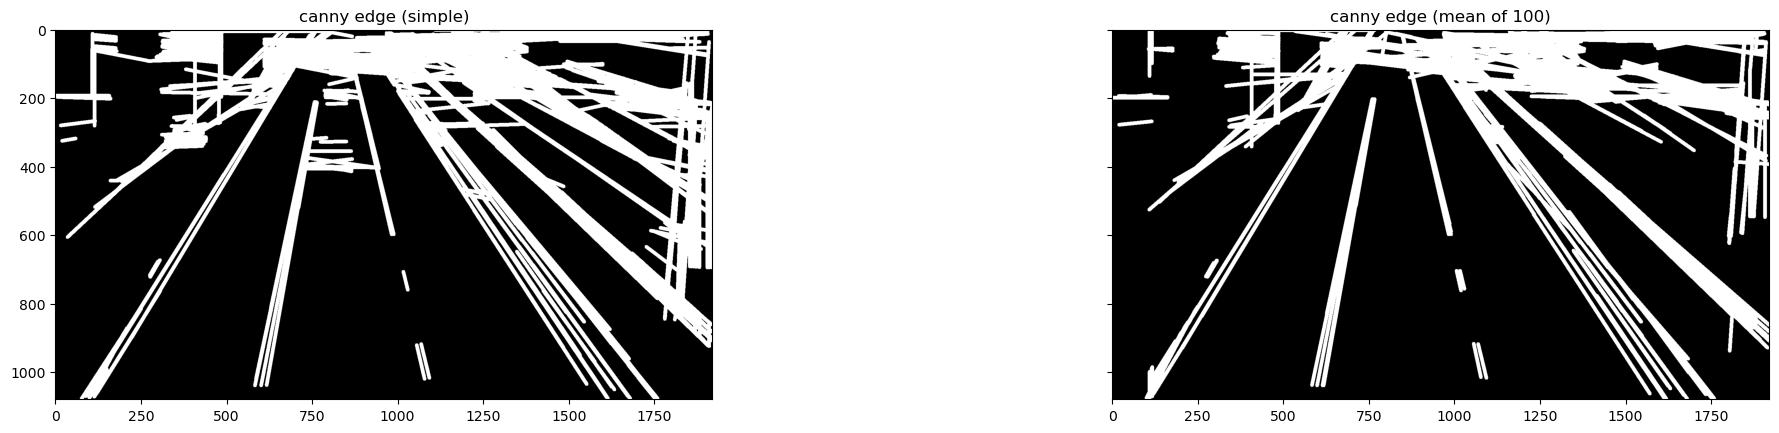

In [74]:
# Other idea: Apply mean over a series of images to remove random noise / moving objects
clean_img = paint_lines(canny_edge_detector(images[0]))
mean_img = paint_lines(canny_edge_detector(np.uint8(np.mean(images, axis=0, dtype=int))))
plot_image([clean_img, mean_img], cmap='gray', captions=["canny edge (simple)", f"canny edge (mean of {len(images)})"])

## Lane Detection via Car centroid / Object detection

In [10]:
import tensorflow as tf
import tensorflow_hub as hub

detector = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1")

rgb_img = images[0]
rgb_img= cv2.resize(rgb_img,dsize=(1333,800), interpolation = cv2.INTER_CUBIC)

Metal device set to: Apple M1


2022-11-15 18:48:03.218444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 18:48:03.218865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


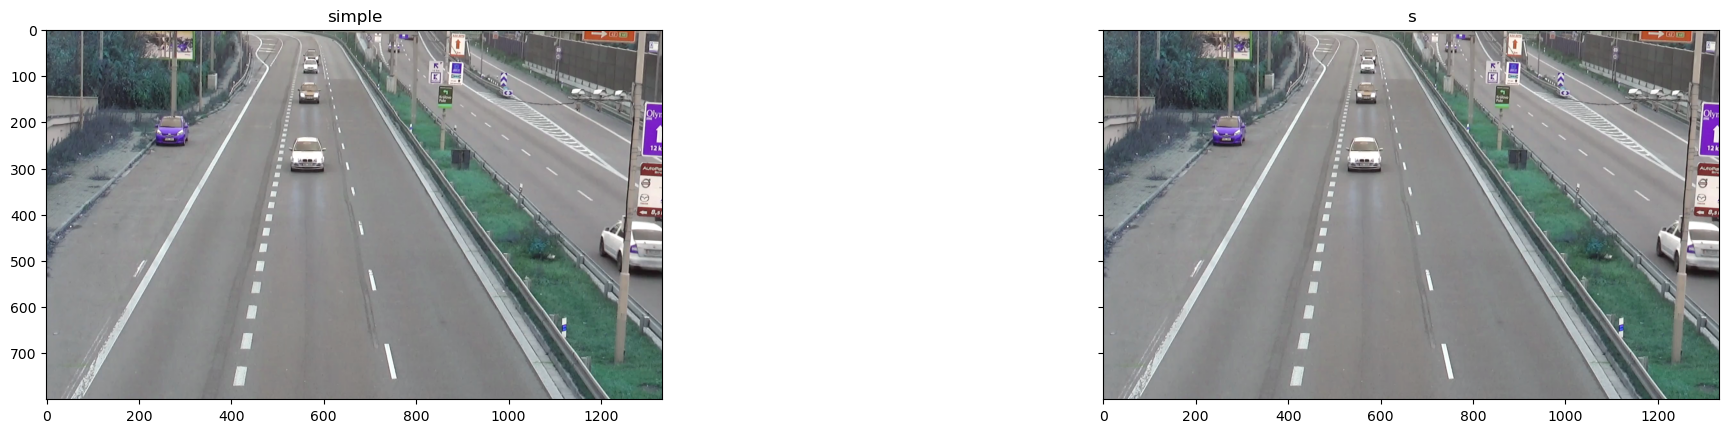

In [11]:
plot_image([rgb_img, rgb_img], cmap='gray', captions=["simple", "s"])

In [12]:
rgb_tensor: tf.Tensor = tf.convert_to_tensor(rgb_img, dtype=tf.uint8)
# print(rgb_tensor.shape)
# rgb_tensor = tf.transpose(rgb_tensor, [1,0,2])
print(rgb_tensor.shape)
rgb_tensor = tf.expand_dims(rgb_tensor , 0)
result = detector(rgb_tensor)
result.keys()

(800, 1333, 3)


2022-11-15 18:48:14.685036: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 18:48:14.702976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


dict_keys(['detection_anchor_indices', 'detection_boxes', 'detection_classes', 'detection_multiclass_scores', 'detection_scores', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores'])

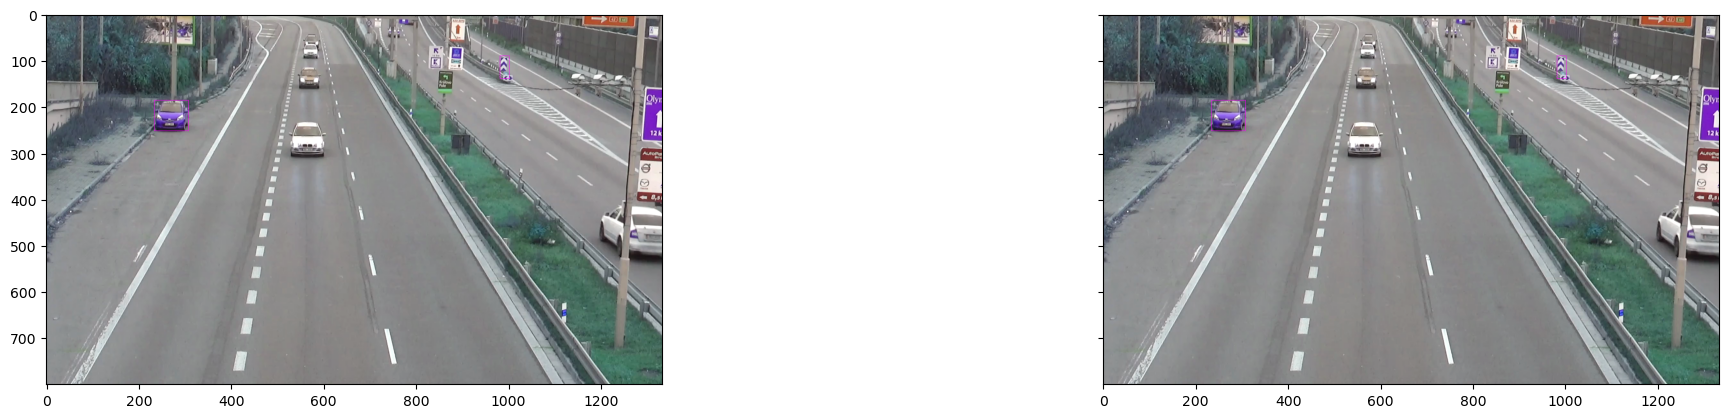

In [13]:
colors = np.array([[1.0, .0, 1.0]])
out_img = tf.image.convert_image_dtype(
    rgb_tensor, tf.float32, saturate=True, name=None
)
out_img = tf.image.draw_bounding_boxes(
    out_img, result["detection_boxes"], colors, name=None
)
out_img = out_img.numpy()[0, :]
plot_image([out_img, out_img],  captions=["", ""])

In [14]:
def prepare_image(img):
    img = cv2.resize(img, dsize=(1333,800), interpolation = cv2.INTER_CUBIC)
    img_tensor: tf.Tensor = tf.convert_to_tensor(img, dtype=tf.uint8)
    img_tensor = tf.expand_dims(img_tensor, 0)
    return img_tensor

def detect_image(img_tensor):
    result = detector(img_tensor)
    return result

def paint_boxes(img_tensor, result):
    out_img = tf.image.convert_image_dtype(
        img_tensor, tf.float32, saturate=True, name=None
    )
    out_img = tf.image.draw_bounding_boxes(
        out_img, result["detection_boxes"], colors, name=None
    )
    out_img = out_img.numpy()[0, :]
    return out_img

def detect_images(images):
    out = []
    for idx, img in enumerate(images):
        print(f" Calc img {idx} / {len(images)}")
        img_tensor = prepare_image(img)
        r = detect_image(img_tensor)
        img_with_boxes = paint_boxes(img_tensor, r)
        out.append(img_with_boxes)
    return out

In [15]:
images_with_boxes = detect_images(images[::10])

 Calc img 0 / 10
 Calc img 1 / 10
 Calc img 2 / 10
 Calc img 3 / 10
 Calc img 4 / 10
 Calc img 5 / 10
 Calc img 6 / 10
 Calc img 7 / 10
 Calc img 8 / 10
 Calc img 9 / 10


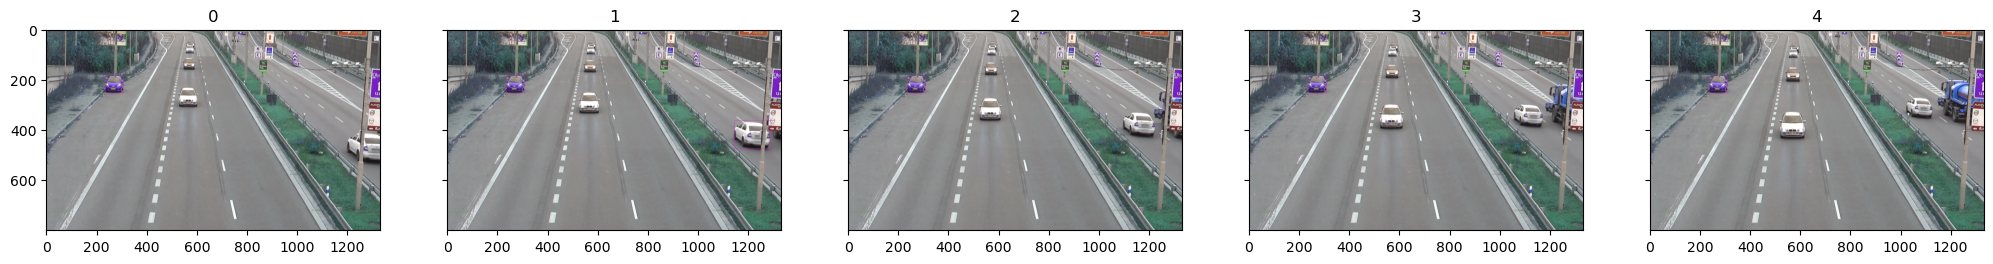

In [16]:
plot_image(images_with_boxes[:5],  captions=[f"{i}" for i in range(len(images_with_boxes))])

## Optical Flow
https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html

In [20]:
from itertools import cycle

feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

color = np.random.randint(0, 255, (100, 3))

# Take first frame and find corners in it
first_frame = images[0]
old_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(first_frame)

for frame in cycle(images[1:]):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)
    cv2.imshow('frame', img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv2.destroyAllWindows()